Timo Haller University of Bonn, M.Sc. Economics, 16th August 2020

# Computational Statistics - Term paper

In [1]:
setwd("/Users/timohaller/Desktop/CausalForests/Project/")

library(foreign)
library(mvtnorm)
library(MASS)
library(sandwich)
library(lmtest)
library(ggplot2)
library(grf)
library(bindata)
library(fitdistrplus)
library(Rfast)
library(car)
library(tidyr)
#library(IRdisplay)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: survival

Loading required package: Rcpp

Loading required package: RcppZiggurat


Attaching package: ‘Rfast’


The following objects are masked from ‘package:mvtnorm’:

    dmvnorm, dmvt, rmvnorm, rmvt


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:Rfast’:

    bc




In [2]:
setwd("/Users/timohaller/Desktop/CausalForests/Project/")

source("aux/CRF function obs.R")
source("aux/CRF function noise.R")

In [3]:
### Load and clean data

setwd("/Users/timohaller/Desktop/CausalForests/Project/")

# Read in data

data <- read.csv("data/data.csv")

# Select relevant variables 

depvar <- "expec_stockret_perc_t01"
covariates <- c("high","female", "atleast_bachelor", "z_conf_prior","prior_t01","prior_squ_t01")
selection_variables <- c("housing")

data = subset(data,select=c(depvar,covariates,selection_variables))

# Rename the variables

names(data) = c("stockret", "high", "female","edu","conf","prior","prior_squ","housing")

# Select relevant observations and drop missing values

data = data[data$housing == 0,]

# Drop missing values

data =  data[complete.cases(data), ]
data$housing = NULL

## Table of contents

1. [Introduction](#introduction) 
2. [Theoretical Background](#theory) 
3. [Empirical Application](#application)     
4. [Simulation Study](#simulation) 
    1. [Data Generating Process](#sim_dgp)
    2. [Number of Observations](#sim_obs)
    3. [High-dimensional Data](#sim_highdim)
5. [Conclusion](#conclusion)
6. [Bibliography](#bib)

## 1. Introduction <a name="introduction"></a>

Usually, machine learning (ML) algorithms are used for prediction but not for causal inference. However, recently researchers developped methods that exploit the prediction power of ML algorithms to estimate causal effects. One example for these "new" approaches is the *causal forest* method, which was designed by Athey and Imbens (2016), Wager and Athey (2018) and Athey et al. (2019). The causal forest basically extends the popular *random forest* approach, which was pioneered by Breiman in 2001, in order to estimate causal effects. <br>
<br>
Traditionally, linear regression models estimated with the ordinary least squares (OLS) estimator have been the dominant toolkit of economists to conduct inference (see Ratkovic 2019). Under certain assumptions, linear regression models can be used to estimate causal effects. However, simple regression models typically suffer from high dependence on the model specification (see ibid.), small datasets and high-dimensional datasets.  <br> 
The following work will shed light on whether causal forests can solve the problems of the linear model and thus enrich the existing toolbox of econometricians. Therefore, I designed two simulation studies which compare the performance of causal forests and linear models with different specifications where the data sample is varied in terms of the number of observations and number of regressors. Thereby, I use data from a randomized information experiment which was conducted by the economists Peter Maxted, Christopher Roth and Johannes Wohlfahrt in the US in 2019. It is my goal to estimate the (conditional) effect of the information treatment on people's expectations of stock returns. Note that the content and the economic interpretation of this estimation is incidental for my work. Instead, this example serves as a motivation for my simulation studies, whose data generating process (DGP) approximates the DGP of the real data. <br>
<br>
My work is structured as follows. In the next section, I will give some theoretical background information about causal forests. Since the theory of causal forests is quite complex, the section will give a more intuitive explanation on how causal forests function rather than a mathematical formulation on their asymptotic behavior. In section 3, I will explain the real data on which my simulation studies are based on. The main part of this paper is section 4, which includes the simulation studies. First, I will describe the data generating process of the simulation study (subsection 4.1). Subsequently, I will compare the performance of CRF with different OLS specifications for varying sample sizes (subsection 4.2) and varying number of regressors (4.3). Finally, section 5 will summarize my results.    

In [4]:
# Making precise predictions does not necessarily require to understand how certain variables affect the outcome. Nonetheless, most scientific questions are causal. For example, one is interested in the causal treatment effect of a drug on the health of people. Thereby, one distinguishs between the average treatment effect (ATE) and the conditional treament effect ()  

## 2. Theoretical Background <a name="theory"></a>

**The roots of causal forests**

Causal forests, as proposed by Athey et al. (2019), is a ML method based on the random forest algorithm of Breiman (2001) (see Wager and Athey (2018)). Breiman's method and subsequent methods that build up on it are currently part of the list of most succesful approaches to deal with "modern", high-dimensional datasets (see Biau and Scornet (2016)). High-dimensionality means that the number of features $p$ is allowed to be (much) larger than the number of observations $n$ ($p >> n$). Classical methods, like OLS regressions, are not applicable in these cases because they require that the number of observations is much larger than the number of regressors ($n >> p$). Conversely, random forests can be used to regress or classify very accurately even in the presence of small and high-dimensional samples (see ibid.)). Roughly speaking, the method works as follows: One uses bootstrap sampling to grow $B$ regression trees and averages the predictions across all trees. Thereby, different to *bagging* or *boosting* aggregation, each tree is grown by only considering a subset of features. This decreases the correlation between trees and thus the variance of the forest becomes smaller (see James et al (2013)). <br>
Nevertheless, random forests also suffer some problems. First, like most machine learning algorithms, it can be only used for prediction and not for causal inference, which would be more relevant for economists. This means that it can for example predict which customer group will most likely buy a product, but not how much certain characteristics (like e.g. gender, income) increase the probability of a buy.  Furthermore, although random forests have proven their strength in many empirical applications, there exists no fundamental theory about the properties of random forests. This is because capturing the underlying theory of causal forests with rigorous mathematics is very complex. Thus, theoretical results about random forests (e.g. their asymptotic behavior) have been only found for restricted settings (see Biau and Scornet (2016)). <br>
Causal forests were designed to circumvent these limitations. They can be used to estimate heterogeneous treatment effects. Still, causal inference requires also an asymptotic theory of the causal forest estimates (see Wager and Athey (2018)). Wager and Athey (2018) show that, under certain assumptions, the causal forest estimates are consistent and asymptotically normally distributed. Hence, causal forests allow causal inference by giving unbiased predictions for which confidence intervals can be constructed. 


Wager and Athey (2018) base their work on the popular Rubin outcome model (see Rubin (1974) as cited in ibid.). Assume there are $n$ observations labeled by $i$ which consists of an outcome $Y_{i}$, a binary treatment $W_{i} \in \{0,1\}$, and a feature vector $x_{i} \in X_{i}^{p}$. Define $Y_{i}^{1}$ and $Y_{i}^{0}$ as the outcome if the observation received and did not receive the treatment, respectively. Hence, the average treatment effect (ATE) is defined as follows:

$(1) \qquad \mu = E\left[Y_{i}^{1} - Y_{i}^{0} \right]$

Consequently, the ATE measures the effect of the treatment on the overall population. It is the same for all individuals independent from their characteristics. On the other hand, the conditional average treatment effect (CATE) is very similar but takes the characteristics of each observation into account. Hence, the CATE depends on the characterisitics of each observation $x_{i}$. It is denoted by $\tau(x)$ and defined as follows$:^{1}$

$(2) \qquad \tau(x) = E\left[Y_{i}^{1} - Y_{i}^{0} \vert X_{i} = x_{i} \right]$

It is the goal of the causal forest to estimate $\tau(x)$. The "fundamental problem of causal inference" (Holland (1986) as cited in Athey and Imbens (2016)) is that for each individual only one potential outcome, i.e. either $Y_{i}^{1}$ or $Y_{i}^{0}$, can be observed. Accordingly, statistical methods for causal inference (and thus causal forests) must find a way to estimate the effect despite the fundamental problem. Therefore, usually additional assumptions are necessary. The main assumption of causal forests is "unconfoundedness", which was already previously used in other contexts (see Rubin and Rosenbaum (1983) as cited in ibid.). It requires the following: 

$(*) \qquad \left\{ Y_{i}^{0}, Y_{i}^{1} \right\} \perp \!\!\! \perp W_{i} \, \vert \, X_{i} \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$  (Unconfoundedness)

In words, the potential outcomes are independent from treatment assignment conditional on $X_{i}$. Intuitively, this ensures that treatment assignment of observations with similar characteristics $x$ is quasi-randomily drawn. Note that the assumption is fulfilled in randomized controlled *randomized controlled trials* (RCTs). However, the unconfoundedness assumption is rather strong in observational settings. As described previously, the estimated CATEs, $\hat{\tau}(x)$, should be consistent and asymptotically normally distributed, i.e (see Wager and Athey (2018))):

$(3) \qquad \hat{\tau}(x) - {\tau}(x) \, \big/ \, \sqrt{\text{Var}\left[\hat{\tau}(x)\right]} \xrightarrow{d} \mathcal{N}\left(0,1\right)$ 

In order to achieve this, two further assumptions must be made (see ibid.):

$(**) \qquad E\left[Y^{0} \vert X = x\right]$ and $E\left[Y^{1} \vert X = x\right]$ are Lipschitz continous. $\qquad \qquad \qquad \quad $ (Continuity) <br>
<br>
$(\textit{***}) \qquad \exists \epsilon > 0 \quad \textit{s.t.} \quad \epsilon < P \left[W = 1 \vert X = x \right] < 1 - \epsilon \quad \forall x \in X \quad \quad \,\,\, \qquad \qquad $ (Overlapping) 

The continuity assumption demands that the conditional mean functions are Lipschitz continous$.^{1}$ This is a usual assumption for the asymptotic theory of random forests (see ibid.). The overlapping condition implies that treatment assignment is possible and not sure for any feature vector $x$. This means that e.g. in a randomized medical trial it is possible that only men receive a drug. Hence, if $n$ is large enough, for any feature vector $x$ there are enough treated and controlled observations. Achieving the asymptotic behavior of the estimate as in (2), besides the assumptions $(*) - (\textit{***})$ a special modification of Breiman's (2001) random forest is needed (see ibid.). <br>
In the following subsection I will describe the causal forest algorithm according to procedure 1 in Wager and Athey (2018). In the simulation studies (see section 4) I use a similar but not exactly equal version of the causal forest algorithm, which is described in Athey et al. (2019) and implemented in the <code>causal_forest</code> function of the <code>grf</code> R-package (see Athey et al. (2019) and Tibshirani (2020)). I decided to do so because Athey's et al. (2019) algorithm is just a minor extension of procedure 1 in Wager and Athey (2018), but it is much more sophisticated and harder to explain. Instead, I will describe the more intuitive Wager and Athey (2018) algorithm and will describe briefly how it differs from the version in Athey et al. (2019).

A causal forest consists of $B$ individiual causal trees. The forest aggregates the estimated effects of the individuals trees, $\hat{\tau}_{b}(x)$ for $b \in (1,...,B)$, simply by taking their average (see Wager and Athey (2018)), i.e. 

$(4) \qquad \hat{\tau}(x) = \frac{1}{B}\sum\limits_{b=1}^{B} \hat{\tau}_{b}(x)$ .  

Growing many trees instead of just oneis necessary to decrease the variance of the estimates (see James et al. (2013)). <br>
Estimating $\hat{\tau}_{b}(x)$ requires to grow causal trees. This is done by following two steps: First, a *causal tree* is built and second, the causal effects are estimated for each *leaf* of the tree. A *tree* is a partitioning $\Pi$ of the p-dimensional future space $X^{p}$, consisting of $L$ elements $\ell$ that are called *leafs*. Formally (see Athey and Imbens (2016)):

$(5)\qquad \Pi = \left\{\ell_{1},...,\ell_{L}\right\}$ with $\cup_{j=1}^{L}\ell_{j} = X^{p}$

Since $\Pi$ is a partition, for each feature vector $x$ there exists a unique $\ell$ such that $x \in \ell(x;\Pi)$. Hence, for any given feature vector $x$, the estimated counterpart of $\tau(x)$ (see equation (1)) is simply the difference between the estimated average outcome of treated and untreated observations in the leaf $\ell(x;\Pi)$ where $x$ belongs to (see Wager and Athey (2018)):

$(6)\qquad \hat{\tau}_{b}(x) = \frac{1}{\vert \{ i\,:\, W_{i}\,=\,1\,,\,x_{i} \,\in\, \ell(x;\Pi) \}\vert} \sum\limits_{\{ i: W_{i}=1,x_{i} \in \ell(x;\Pi) \}} Y_{i} - \frac{1}{\vert \{ i\,:\, W_{i}\,=\,0\,,\,x_{i} \,\in\, \ell(x;\Pi) \}\vert} \sum\limits_{\{ i: W_{i}=0,x_{i} \in \ell(x;\Pi) \}} Y_{i}$

Note that there are many partitions $\Pi$ possible to split $X^{p}$. A tree algorithm must find the "best" partitioning for a given purpose. Therefore, one needs to specify a splitting criterion that decides where the splits are set. Traditional random trees like in Breiman (2001) seek to make as good predictions as possible. For this purpose, the *Classification And Regression Trees* (CART)-splitting criterion turned out to be a good choice (see Biau and Scornet (2013)). It basically chooses the partitioning in a way that the mean-squared error (MSE) of the predictions is minimized. However, the purpose of causal trees is not to predict outcomes but to estimate heterogenous treatment effects. The conventional CART criterion is not applicable in these cases, because unit-level causal effects $\tau_{i}$ can not be observed (see Athey and Imbens (2016)). Instead, Athey and Imbens (2016) derive a different splitting criterion for causal trees that is used in the algorithm of Wager and Athey (2018) aswell. Thereby, they assume that the tree is *honest*. A tree is honest if it uses each $Y_{i}$ in the training data either to estimate the within-leaf treatment effect $\tau$ or to decide where to place the splits of the tree, but not both (see Wager and Athey (2018)). Assuming honesty is reasonable because it achieves that the partition is exogenously given when the treatment effects within leafs are estimated. Thus, the estimates of $\tau(x)$ are not biased. On the other hand, honesty reduces the applied sample which increases the variance of the estimates. Hence, there is a trade-off between bias and variance of the estimated treatment effects. However, Athey and Imbens (2016) think that the positive bias reduction effect dominates, especially because unbiased estimates are needed for correct confidence intervals which are necessary for causal inference. <br>
Wager and Athey (2018) ensure honesty as follows: For any given training sample with $N$ observation, first a random subsample of size $s < N$ is drawn. This set is further halved into two disjoint subsets (i.e. no observation is in both sets). Denote these sets $\mathcal{I}$ and $\mathcal{J}$ and their cardinality by $N_{\mathcal{I}} := \lfloor{s/2}\rfloor$ and $N_{\mathcal{J}} := \lceil{s/2}\rceil$$.^{2}$ Suppose that the splits are choosen by using any data from sample $\mathcal{J}$ but only $W$ and $x$ observations and not $Y$ observations from sample $\mathcal{I}$. Note that the sample splitting does not "waste" observations here. The samples $\mathcal{I}$ and $\mathcal{J}$ are newly determined for a new subsample $s$. Hence, although for a single tree an observation is either used for setting the splits or predicting, for some trees each observation will participate in each sample $\mathcal{I}$ and $\mathcal{J}$ (see ibid.). <br>
Athey and Imbens (2016) derive that an appropriate splitting rule for a causal forest maximizes $-\widehat{\textit{EMSE}}_{\tau}$, which stands for the estimation of the negative expected MSE of $\tau$. Hence, the partitioning $\Pi$ must maximize the following statement (see ibid.):    

$(7) \qquad -\widehat{\textit{EMSE}}_{\tau}(\mathcal{J},N^{\mathcal{I}},\Pi) = \frac{1}{N^{\mathcal{J}}}\sum\limits_{i\in \mathcal{J}} \hat{\tau}_{b}^{2}(X_{i};\mathcal{J},\Pi) - \left(\frac{1}{N^{\mathcal{J}}} + \frac{1}{N^{\mathcal{I}}} \right) \cdot \sum\limits_{\ell \in \Pi} \left(\frac{N}{N_{treat}} S^{2}_{\mathcal{J}_{treat}}(\ell) + \frac{N}{N-N_{treat}} S^{2}_{\mathcal{J}_{control}}(\ell)\right)$ 

Thereby, $S_{\mathcal{J}_{treat}}^{2}$ and $S_{\mathcal{J}_{control}}^{2}$ are the within-leaf variances of the estimated average outcome for treated and untreated observations, respectively. The parameter $N$ is the number of training observations and $N_{treat}$ and $N_{control}$ are the number of treated and untreated observations, respectively. Note that the splitting rule only depends on sample $\mathcal{J}$ and $N^{\mathcal{I}}$ which is in accordance with the honesty condition. Equation (5) consists of two terms, where the first one is always positive and the second is always negative. The first term includes the average of the squared estimated conditional treatment effects. Accordingly, partitions that find strong heterogeneity in treatment effects are rewarded. On the other hand, the second term implies that increasing the variance of leaf estimations is penalized (see Athey and Imbens (2016)). The penalization is stronger for small sizes of $s$ and unequal number of treated and untreated observations. <br>
After the best tree according to (5) was found, in a next step the treatment effects for each leaf are estimated. This is done by simply solving equation (4) for all observations in subsample $\mathcal{I}$. Note that using observations from subsample $\mathcal{J}$ would violate the honest assumption and thus $\hat{\tau}(x)$ would be biased. <br>
There are several tuning parameters that must be set in order to grow the causal tree. One way to identify appropriate tuning parameters would be via cross-validation. One important parameter is the minimum number of observations a leaf has to contain denoted by <code>min.node.size</code>$.{3}$ It determines when the algorithm stops to further split in finer leafs. Also important is the parameter <code>mtry</code>. It determines which features are available for splitting in each tree. Like in Breiman's (2001) random forests, it can make sense to allow for less features in the tree-building phase in order to decorrelate the trees and thus to achieve more precise predictions. <br>
As mentioned previously, the causal tree algorithm described above is not exactly the one I use in the simulation studies with the <code>grf</code> package. Thereby, the splitting criterion is replaced by an approximated gradient-based loss criterion which is more computationally efficient. Furthermore, they apply a special weighting scheme to aggreate the predicitons of the trees instead of just taking their simple average as in equation (3).  
In combination with the more flexible form of generalized random forests, this makes the <code>grf</code> version better in terms of dealing with violations against the unconfoundness condition and treatment heterogeneity$.^{4}$ (see Athey et al. (2019))

___
$^{1}$ Note that by the law of iterated expectations the following holds: $\mu = E\left[E\left[Y_{i}^{1} - Y_{i}^{0} \vert X_{i} = x_{i} \right]\right] = E\left[\tau(x)\right]$ <br>
$^{1}$ Lipschitz continuity is more stringent than the common continuity definition. It requires that the rate of change of a function is bounded.    
$^{2}$ The floor and ceiling function ensures that the size of sets $\mathcal{I}$ and $\mathcal{J}$ are always integers, also in cases where s is odd. <br>
$^{3}$ I use the notation from the R-package <code>grf</code> here (see Tibshirani (2020)). <br>
$^{4}$ Check Athey et al. (2019) for a comparison between the different causal forests algortihms in these circumstances. 

## 3.  Empirical Application

### 3.1 The survey data

In my simulation study, I estimate the CATE of an information treatment on people's long-term expectations of stock returns. Therefore, I use survey data from an experiment which was conducted by Peter Maxted, Christopher Roth and Johannes Wohlfahrt in the US in 2019. The goal of the experiment is to study the effect of long-term asset expectations on short-term consumption. The evaluation of the survey is not published yet. I have access to the data because I work as an student research assistant for Christopher Roth at the *briq - Institute on Behavior & Inequality* in Bonn. I am very thankful that the researchers allowed me to use the data for this project. <br>
<br>
The original dataset contains online survey data from 8,247 respondents. The people were divided into four similarly sized treatment groups. Two groups were treated with an information treatment containing a forecast about  the long-term development of stockprices. The other two groups received a similar information treatment about houseprices. In my analysis, only the 4,138 observations with the stockprice treatment are considered. These observations are further split randomly into two similarly sized groups. One group received a very optimistic forecast which expects that the average annual return of stocks in US stock markets will be 10 % per year over the next 10 years. The other group received a similar but less optimistic forecast which estimates the average annual return to be 2 %. The exact information treatment can be found in the appendix. I define the dummy variable *high* as the treatment variable. If its value is one, the person received the optimistic forecast (treatment group) and if it is zero, the person received the neutral forecast (control group). Note that the treatment was randomly assigned by the construction of the experiment. The treatment so to say shifts peoples' expectations about their assets exogeneously and hence it is possible to study the causal effect of expectations on different outcomes. I want to examine whether people who received the optimistic forecast indeed expect a higher annual return of the US stock market over the next ten years. The outcome variable *stockret* contains the respective answers. The respondents could state any estimate between -100 % and <nobr> 100 $\%^{1}$ </nobr> with up to two decimal places. In the following subsection I will build up a simple but profound linear model which uses the treatment variable *high* in combination with further covariates to explain the outcome variable *stockret*.

### 3.2 Linear model of stock return expectations

The effect of the treatment on the outcome is expected to be positive. However, one has to expect that the treatment effect varies for different subgroups of people. For example, it may be the case that one gender is more sensitive in adjusting its stock return expectations after receiving the treatment. The same could be the case for educated and less educated persons. Very important is also to consider peoples' expectations on how stock returns develop *before* they were confronted with the information treatments. Hence, further covariates are needed to consider potential effect heterogeneity. Fortunately, the survey collected a lot of information about other beliefs and demographic characteristics of the respondents. The dummy *female* indicates whether a person is a women. Another dummy called *edu* marks persons that hold a bachelor's or higher degree. The variable *prior*  measures peoples' stock return expectations before they received the treatment. The underlying question is very similar to the one of the outcome *stockret*, such that the answers were allowed to be between <nobr>-100 %</nobr> and <nobr> 100 % </nobr> with up to two decimal places. Additionally, the categorical variable *conf* measures how confident people are about their prior expectation. The persons could select one out of the five following answers: *Extremely confident*, *Very confident*, *Somewhat confident*, *Not very confident*, and *Not at all confident*. Since the interpretation of this scale is subjective, the answers were normalized into a standard normal distributed variable. <br>

In a next step, I regress *stockret* on the treatment variable and the other covariates. Note that usually the specification of an econometric model should be based on economic theory. Otherwise the estimated coefficients can not be interpreted properly. However, in our case the interpretation of the coefficients is incidental. The model will be used later as a blueprint for the DGP of the simulation studies. It must not "tell a story" about how each variable affects the outcome. Instead, it has to fit the data well and must be somehow complex. It turned out that the following model is suitable for our purpose:

$(1) \qquad \textit{stockret} = \hat{\beta}_{0} + \hat{\beta}_{1} \, \textit{high} + \hat{\beta}_{2} \, \textit{female} + \hat{\beta}_{3} \, \textit{edu} + \hat{\beta}_{4} \, \textit{prior} + \hat{\beta}_{5} \, \textit{prior_squ} + \hat{\beta}_{6} \, \textit{conf} + \hat{\beta}_{7} \, {high} \times \, \textit{female} + \hat{\beta}_{8} \, {high} \times \, {edu} + \hat{\beta}_{9} \, {high} \times \, {prior} + \hat{\beta}_{10} \, {high} \times \, {prior\_squ} + \hat{\beta}_{11} \, {high} \times \, \textit{conf} + \hat{\beta}_{12} \, \textit{edu} \times \, \textit{conf} + \hat{\beta}_{13} \, \textit{high} \times \textit{edu} \times \textit{conf} + \hat{\beta}_{14} \, \textit{prior} \times \textit{prior_squ} + \hat{\beta}_{15} \, \textit{high} \times \textit{prior} \times \textit{prior_squ} + \epsilon$ 

where $\epsilon$ denotes the idiosyncratic error term. Note that the variable index is left out for readibility, because the data are crosssectional. For readibility, one can rewrite equation (1) as follows:

$(1*) \qquad stockret = \hat{\beta}_{0} + \textit{high}\,\#\#\,\textit{female} + \textit{high}\,\#\#\,\textit{edu}\,\#\#\,\textit{conf} + \textit{high}\,\#\#\,\textit{prior}\,\#\#\,\textit{prior_squ} + \epsilon$ 

where $\,\#\#\,$ stands for imputing the variables and all their interactions with each other$.^{2}$ Hence, *female* is one-way interacted with *high*. On the other hand, *high* has two two-way interactions with both *edu* and *conf* as well as with *prior* and *prior_squ*, respectively. Note that $\textit{prior} \,\#\#\, \textit{prior_squ}$ basically means that a cubic version of *prior* and its interaction with *high* is added to the model (see equation (1)). 



In [5]:
# Generate interactions

high_female = data$high * data$female 
high_edu = data$high * data$edu
high_prior = data$high * data$prior
high_prior_squ = data$high * data$prior_squ
high_conf = data$high * data$conf
edu_conf = data$edu * data$conf
high_edu_conf = data$high * data$edu * data$conf 
prior_prior_squ = data$prior * data$prior_squ
high_prior_prior_squ = data$high * data$prior * data$prior_squ

data_reg = cbind(data,high_female,high_edu,high_prior,high_prior_squ,high_conf,edu_conf,high_edu_conf,prior_prior_squ,high_prior_prior_squ)

fit = lm(data=data_reg,formula="stockret ~ high + female + edu + prior + prior_squ + conf + high_female + high_edu + high_prior + high_prior_squ + high_conf + edu_conf + high_edu_conf + prior_prior_squ + high_prior_prior_squ")
#summary(fit)
coeftest(fit, vcov = vcovHC(fit, "HC1"))

###
print("Number of observations")
dim(data_reg)[1]
print("Adjusted R-squared")
round(summary(fit)$adj.r.squared,3)


t test of coefficients:

                        Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)           3.5243e+00  2.8531e-01 12.3528 < 2.2e-16 ***
high                  1.7132e+00  4.1540e-01  4.1243 3.796e-05 ***
female               -5.1176e-01  2.4506e-01 -2.0883 0.0368333 *  
edu                   2.7862e-01  2.4618e-01  1.1318 0.2577993    
prior                 1.5518e-01  4.8828e-02  3.1782 0.0014937 ** 
prior_squ             9.4570e-04  2.3898e-03  0.3957 0.6923287    
conf                 -5.3260e-01  1.8250e-01 -2.9183 0.0035391 ** 
high_female           7.9010e-01  3.4858e-01  2.2666 0.0234694 *  
high_edu             -8.8328e-01  3.3116e-01 -2.6672 0.0076795 ** 
high_prior            2.9567e-01  7.2841e-02  4.0590 5.023e-05 ***
high_prior_squ       -1.3060e-02  3.7600e-03 -3.4732 0.0005197 ***
high_conf             2.9793e-01  2.4375e-01  1.2223 0.2216784    
edu_conf             -4.8809e-01  2.3588e-01 -2.0693 0.0385873 *  
high_edu_conf         7.7908e-01  3.

[1] "Number of observations"


[1] 3948

[1] "Adjusted R-squared"


[1] 0.202

Rounding the coefficients for convenience gives us the following model: 

$(3) \qquad \widehat{\textit{stockret}} = 3.5 + 1.7 \, \textit{high} - 0.5 \, \textit{female} + 0.3 \, \textit{edu} + 0.15 \, \textit{prior} - 0.5 \, \textit{conf} + 0.001 \, \textit{prior_squ}  + 0.8 \, {high} \times \, \textit{female} - 0.9 \, {high} \times \, {edu} + 0.3 \, {high} \times \, {prior} - 0.013 \, {high} \times \, {prior\_squ} - 0.5 \,\textit{edu} \times \, \textit{conf} + 0.3 \, {high} \times \, \textit{conf} + 0.8 \, \textit{high} \times \textit{edu} \times \textit{conf} - 0.000037 \, \textit{prior} \times \textit{prior_squ} + 0.000139 \, \textit{high} \times \textit{prior} \times \textit{prior_squ} + \epsilon$ 

Most coefficients are estimated precisely at the 1 % and 5 % significance level, respectively. On the other hand, the coefficients of *edu*, *prior_squ*, *high_conf* and *prior_prior_squ* are not significant and the adjusted R-squared is not large (0.2). Hence, the model's ability to explain the real data is limited. Still, I use it as the *true model* to explain *stockret* in the simulation studies in section 4. 

___
$^{1}$ The range was limited to avoid outliers. <br>
$^{2}$ e.g. $\textit{high}\,\#\#\,\textit{female} = \hat{\beta}_{1} \, \textit{high} + \hat{\beta}_{2} \,\textit{female} + \hat{\beta}_{3} \, \textit{high} \times \textit{female}$


## 4. Simulation Study

### 4.1 General setting and hypotheses

The goal of my simulation study is to compare causal forests with the linear model. Particularly, it should become clear under which circumstances which method should be preferred. Therefore, in subsection 4.3 I will vary the number of observations $n$. This will give insights about which method to use if the available training dataset is small and large, respectively. In subsection 4.4, I will add different numbers of additional noise variables and thus vary the dimension of the future space $p$. <br>
I compare the causal forest with two different versions of the linear model. The first linear model estimates *stockret* according to its real specification as in equation (3). I refer to this model as *complex model*. In contrast to this, the second *simple model* estimates *stockret* by just considering the first order interactions. Accordingly, it estimates the following equation:

$(5) \qquad \textit{stockret} = \beta_{0} + \beta_{1} \, \textit{high} + \beta_{2} \, \textit{female} + \beta_{3} \, \textit{edu} + \beta_{4} \, \textit{prior} + \beta_{5} \, \textit{conf} + \beta_{6} \, \textit{prior_squ}  + \beta_{7} \, {high} \times \, \textit{female} + \beta_{8} \, {high} \times \, {edu}$ <br> $\qquad \qquad \qquad \qquad + \,\beta_{9} \, {high} \times \, {prior} + \beta_{10} \, {high} \times \, {prior\_squ} + \epsilon$ 

Hence, it ignores some interaction terms that determines the heterogeneity of the treatment. The motivation for this model is that in practice researchers usually check for heterogeneity only with first term interactions. Thus, it can happen that some important heterogeneity effects are missed due to model misspecification (see Ratkovic (2019)). Causal forests do not suffer this problem, because they do not rely on a specification. Forming expectations about the behavior of the linear models in the simulation studies, it is useful to recall the OLS estimator and its properties. The OLS estimator for $n$ observations and $p$ covariates is given as follows (see Wooldridge (2013)):

$(6) \qquad \hat{\mathbf{\beta}} = \left(\mathbf{X^{\top}}\mathbf{X}\right)^{-1}\mathbf{X^{\top}}\mathbf{Y}$

whereby $\mathbf{X}_{n\times p+1}$ is the design matrix and $\mathbf{Y}_{n\times 1}$ the outcome vector. Equation (6) implicitly implies that the estimator is only unique if the inverse $\left(\mathbf{X^{\top}}\mathbf{X}\right)^{-1}$ exists. This requires that $\mathbf{X}$ is not multicollinear, i.e. that it has independent columns. This can never be the case if $p+1 > n$. Even in the case with slightly fewer independent variables than covariates ($p+1 < n$ and $p+1 \approx n$), the estimates can become very bad due to imperfect multicollinearity. Thus, the linear model requires that the number of observations is much larger than the number of independent variables ($p+1 \ll n$). However, if this assumption is met and the linear model is specified correctly, the asymptotic theory of the OLS estimator says that $\hat{\mathbf{\beta}}$ is unbiased for large $n$. Note that both the *complex* and *simple* model is correctly specified, because both do not omit any relevant variables. Accordingly, the estimated ATE of high should be unbiased in both models. However, since the *simple* model does not capture the whole treatment effect heterogeneity, its estimated CATE $\tau(x)$ (see equation (2)) will be incorrect. <br>
Consequently, the linear model can not be used for high-dimensional datasets and may perform badly for datasets with few observations and many covariates. Random forests though can deal with those datasets very well according to Biau and Scornet (2016). Since causal forests are an extension of random forests (see Wager (2018)), it seems obvious that they also should outperform the linear model in these settings. On the other hand, the linear model may be more accurate than causal forests for low-dimensional data with many observations. This is because in our example the true *stockret* depends linearly on the covariates (see equation (4)). The linear model is designed for capturing linear relationships, whereas causal forest as a tree-based method is not (see James et al. (2013)). <br>

Summing up, the simulation studies will be used to verify the following hypotheses:

1. CRF will perform better than the linear models for small sample sizes.
2. In low-dimensional datasamples with large $n$, the complex linear model will outperform CRF.
3. In any setting, CRF will be better in estimating the CATEs than the misspecified simple model.
4. Linear models  can not be used for high-dimensional data $\left(p+1 > n\right)$. For $p+1 < n$ and $p+1 \approx n$ they will perform very bad. This becomes more severe if the covariates are correlated.
5. CRF can be used for high-dimensional data. However, the preciseness of its estimates will also decrease by adding more covariates.


<br>
In the subsequent simulation studies, each simulation is repeated $m$ times (the default of $m$ is 50). The simulations are indexed by $i$. I compare the models based on two key figures. The first one, $\widehat{\textit{EMSE}}_{\tau}$, is the estimated expected  MSE of the CATE (see equation (2)):

$(7) \qquad \widehat{\textit{EMSE}}_{\tau} = \frac{1}{m} \, \sum\limits_{i=1}^{m} \frac{1}{n}\left(\hat{\tau}_{i}(x) - \tau_{i}(x)\right)^{2}$


Analogously, $\widehat{\textit{EMSE}}_{\mu}$ denotes the estimated expected MSE of the ATE:

$(8) \qquad \widehat{\textit{EMSE}}_{\mu} = \frac{1}{m} \, \sum\limits_{i=1}^{m} \frac{1}{n}\left(\hat{\mu}_{i} - \mu_{i}\right)^{2}$

This means, for each simulation the average squared difference between the estimated and true $\tau(x)$ and $\mu$, respectively, is calculated and afterwards averaged across all simulations. Note that this is possbile, because in simulation studies the true ATE and CATEs are known. Furthermore, for each EMSE, smaller values indicate a better fit of the underlying model.    

### 4.2 Data Generating Process

In the previous section I estimated the relationship between *stockret* and the covariates. Equation (3) is used as the true model of the outcome. In a next step, it is necessary to specify the distribution of the independent variables. It is important to also take the correlation structure between covariates into account. Thereby, the distributions of the simulated variables should approximate the distributions of the real variables. Since the underlying DGP is usually very complex, it is only possible to approximate it in a simple way. <br>

The following table gives some summary statistics of the relevant variables:

**Table 1 - Summary Statistics of Variables** 

In [6]:
data_stats = subset(data,select=-c(stockret,prior_squ))

quantiles = data.frame(t(apply(data_stats,2,quantile)))
names(quantiles) = c("Min","Q25","Median","Q75","Max")

sumstats = cbind(Type = c("Dummy","Dummy","Dummy","Categorical","Continous"), round(cbind(data.frame(Mean=colMeans(data_stats), SD = apply(data_stats,2, sd)),quantiles),digits=3))
sumstats

,Type,Mean,SD,Min,Q25,Median,Q75,Max
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
high,Dummy,0.502,0.500,0.000,0.000,1.000,1.000,1.000
female,Dummy,0.778,0.416,0.000,1.000,1.000,1.000,1.000
edu,Dummy,0.473,0.499,0.000,0.000,0.000,1.000,1.000
conf,Categorical,0.408,0.960,-1.833,-0.096,0.772,0.772,1.641
prior,Continous,8.503,9.882,0.000,3.000,5.000,10.000,87.000


**high** <br>
The treatment dummy *high* was randomly assigned to the individuals with probability one half. Thus, *high* is independent from all other covariates. This implies that *high* is not correlated with any other covariate. Accordingly, it is obvious to draw high from a univariate binomial distribution. Formally:

$\qquad \textit{high} \sim B\left(n,\pi = 0.5\right) $

In [7]:
set.seed(123)
N = 10000

sim_high = data.frame(high = rbinom(n = N, prob=0.5,size=1))

**female, edu and conf** <br>
Like *high*, also variables *female*, *edu* and *conf* are discrete variables. However, since these variables are not independent from each other, it would be unappropriate draw each of them from a univariate distribution. This would ignore possible correlations between the variables. The following correlation matrix will give some insights about the correlation structure of the variables:

In [8]:
cor(subset(data,select=c("female","edu","conf")))

,female,edu,conf
female,1.0000000,0.18907979,0.24078416
edu,0.1890798,1.00000000,0.03498882
conf,0.2407842,0.03498882,1.00000000


The variable *female* is correlated positively with both *edu* and *conf*. Furthermore, it seems that there is no correlation between *edu* and *conf*. To investigate this issue further, it is useful to estimate two regression models. First, one estimates *female* on *edu* and *conf* in a logit model. Both coefficients should be significant here. Second, one estimates an ordinal logistic regression model with *conf* as outcome and *female* and *edu* as independent variables. In this model, *female* should have a positive coefficient while *edu* has not. The results of these two regressions are as follows:   

In [9]:
data$conf_new = as.factor(data$conf)

female_fit = glm(data,formula = "female ~ edu + conf",family=binomial(link="logit"))
conf_fit = polr(data,formula="conf_new ~ female + edu")

print("Regression 1: female on edu and conf (Logit)")
coeftest(female_fit)

print("Regression 2: conf on edu and female (Ordinal Logistic Regression)")
coeftest(conf_fit)

[1] "Regression 1: female on edu and conf (Logit)"



z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
(Intercept) 0.700846   0.050323  13.927 < 2.2e-16 ***
edu         0.964693   0.084607  11.402 < 2.2e-16 ***
conf        0.601168   0.041796  14.383 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] "Regression 2: conf on edu and female (Ordinal Logistic Regression)"



Re-fitting to get Hessian





t test of coefficients:

        Estimate Std. Error t value Pr(>|t|)    
female  1.141459   0.071645 15.9321   <2e-16 ***
edu    -0.089801   0.058784 -1.5276   0.1267    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Indeed, the estimated coefficients are as expected. The variable *female* is explained by both *edu* and *conf*, while *conf* is not explained by *edu*. Hence, it is reasonable to draw the simulated variables of *female* and *edu* from a correlated binomial distribution. This is done by using the function <code>rmvbin</code> from the <code>bindata</code> package. Thereby, one has to specify the probabilities that *female*, *edu* and both *female* and *edu* are one. These are stored in a matrix called *commprob* and can be easily derived from the real data (see below). In a next step, the simulated values of *conf* are drawn under consideration of the correlation with *female*. This is done by drawing *conf* from a multivariate binomial distribution, whereby the probabilities of each category depend on the level of *female*. The conditional probabilities (stored in vectors *prob_male* and *prob_female*) are again estimated from the real data.  

In [10]:
N = 10000

### Draw female and edu variables

table_female_edu = table(data$female,data$edu,dnn = c("female","edu"))
mprob = c(sum(data$female)/dim(data)[1],sum(data$edu)/dim(data)[1])
commprob = matrix(c(sum(data$female)/dim(data)[1],dim(data[data$female == 1 & data$edu == 1,])[1]/dim(data)[1]
,dim(data[data$female == 1 & data$edu == 1,])[1]/dim(data)[1],sum(data$edu)/dim(data)[1]),nrow=2,ncol=2)


sim_fem_edu_conf = data.frame(rmvbin(n=N,margprob=as.matrix(mprob),commonprob=commprob))
names(sim_fem_edu_conf) = c("female","edu")

### Draw conf variable 

prob_male = c(data.frame(table(data[data$female == 0,]$conf)/length(data[data$female == 0,]$conf))$Freq)
prob_female = c(data.frame(table(data[data$female == 1,]$conf)/length(data[data$female == 1,]$conf))$Freq)

cat_vector = cat_vector = as.numeric(names(table(data[data$female == 0,]$conf)))

sim_fem_edu_conf$conf = NA

for (i in seq(1,N,1)) {
    
  if (sim_fem_edu_conf[i,]$female == 0) {
    
    sim_fem_edu_conf[i,]$conf = sum(rmultinom(n=1,size=1,prob=prob_male)*cat_vector)
  }
  else {
    
    sim_fem_edu_conf[i,]$conf = sum(rmultinom(n=1,size=1,prob=prob_female)*cat_vector)
  }
}

**prior** <br>
The variable *prior* is the only continous variable in the dataset. Thus, the simulated version of *prior* must follow a continous distribution which is close to the real distribution. In doing so, first one has to find an appropriate distribution function. Subsequently, one must find the correct distribution parameters to match the real distribution as good as possible. <br>
By design of the survey, possible values of *prior* are between -100 % and 100 %. However, most people did not state extreme expectations, especially not in the negative range. Furthermore, the we use a trimmed version of the initial variable at the 1% level. This means the top and bottom percentile was dropped. As a consequence, in our data *prior* ranges between 0 % and 87 %, with mean at 8.5 % and median at 5 % (see Table 1). Thus, a continous distribution function that is defined for non-negative values only is supposed too be a good choice. The following histogram of *prior* helps to get a better idea about how *prior* is distributed:

**Figure 1 - Histogram of prior**

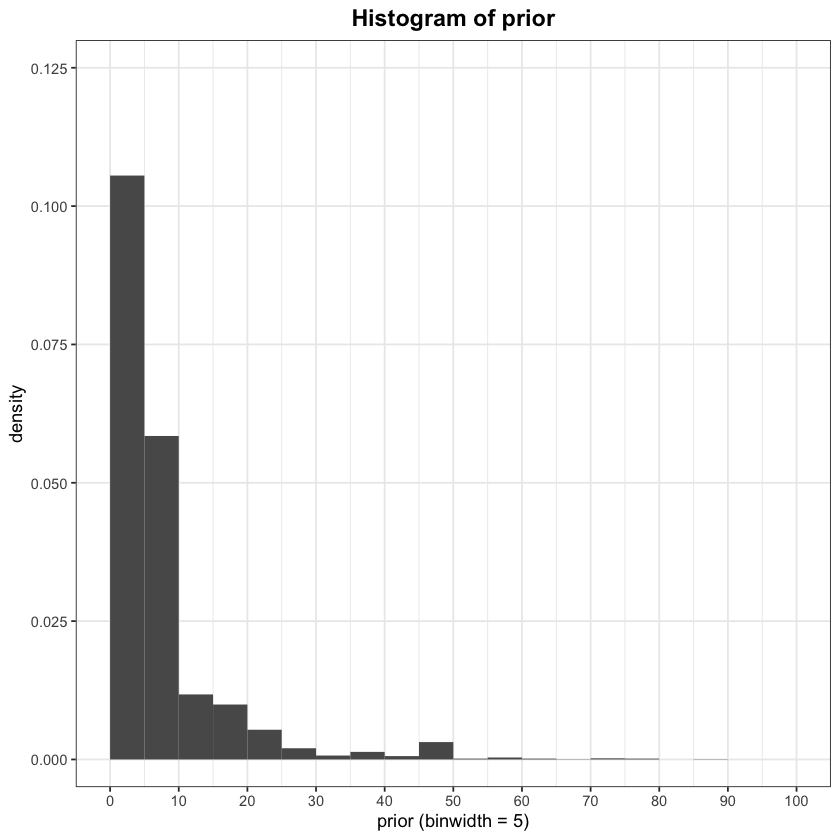

In [11]:
ggplot() + 
    theme_bw() +
    geom_histogram(data=data,aes(x=prior,y=..density..),binwidth=5,color="white",size=0,boundary=0) +
    scale_x_continuous(minor_breaks = seq(0 , 100, 5),breaks=seq(0,100,10),lim=(c(0,100)),,expand=c(0,5)) +
    scale_y_continuous(minor_breaks = seq(0 , 0.1, 0.025),breaks=seq(0 , 0.125, 0.025),lim=(c(0,0.125)),expand=c(0,0.005)) +
    labs(x="prior (binwidth = 5)") + 
    ggtitle("Histogram of prior") +  
    theme(plot.title=element_text(size=14,face="bold",hjust=0.5))

The histogram shows that the vast majority of people (about 82 %) expected an annual stock return between 0 % and 10 % inclusively. Still, there is also a considerable amount of expectations between 10 % and 50 %. Very few people expect an annual stock return of more than 50 %. There are many distributions that may fit the data well, for example the Weibull, gamma, log-normal and exponential distribution **(see McLaughlin 1999)**. However, besides the exponential distribution, they can not estimated with maximum likelihood estimation (MLE) because *prior* contains zero values for which they are not defined$.^{1}$ Hence, I decided to assume a exponential distribution and estimate its *rate* parameter $\lambda$ with MLE. 

**Figure 2 - MLE estimation of prior** 

Fitting of the distribution ' exp ' by maximum likelihood 
Parameters:
      estimate  Std. Error
rate 0.1176085 0.001871625

[1] "Log-likelihood of MLE fit"


[1] -12398

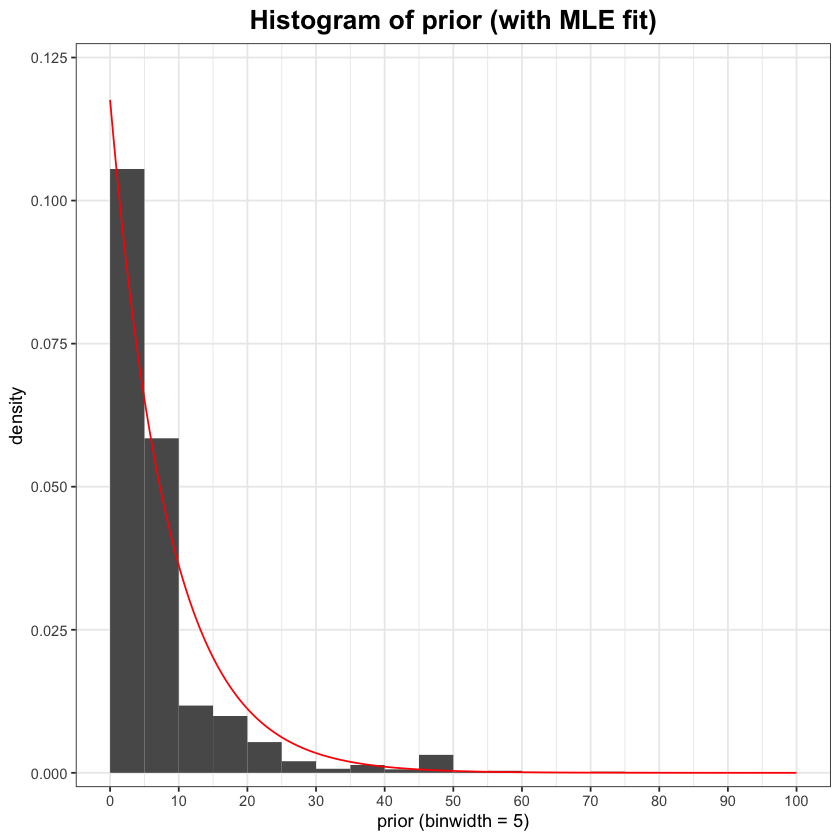

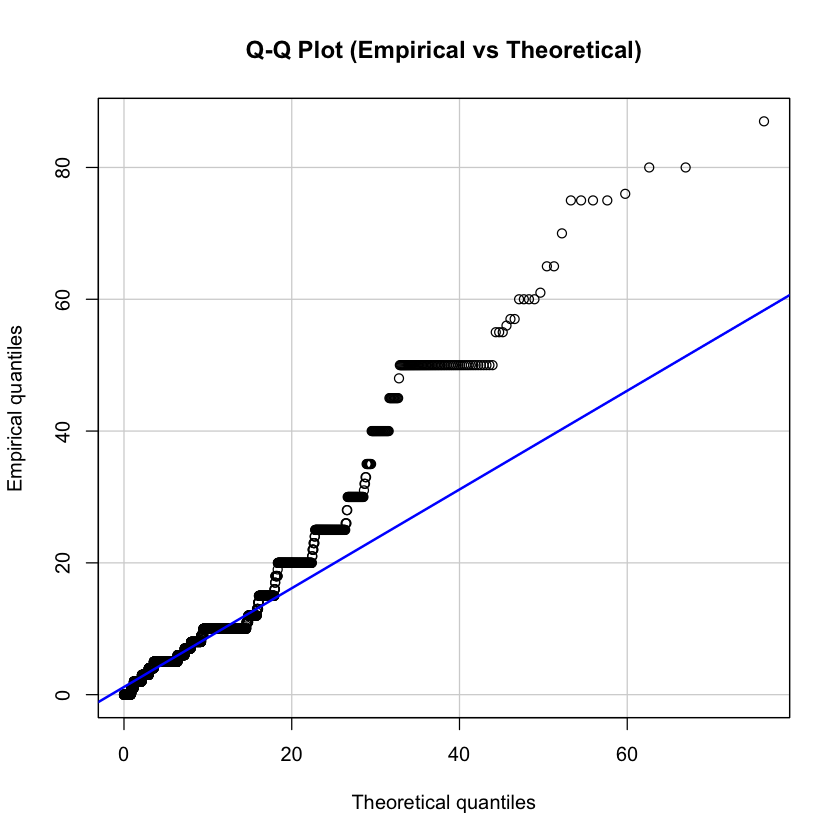

In [12]:
### MLE estimation of prior (assuming exponential distribution)

exp_fit <- fitdist(data$prior, "exp")
exp_fit
print("Log-likelihood of MLE fit")
round(exp_fit$loglik)

exp_fit_density <- data.frame(x=seq(0,100,0.1),density=dexp(seq(0,100,0.1),rate=exp_fit$estimate))

ggplot() + 
    theme_bw() +
    geom_histogram(data=data,aes(x=prior,y=..density..),binwidth=5,color="white",size=0,boundary=0) +
    geom_line(data=exp_fit_density,aes(x=x,y=density),color="red") +
    scale_x_continuous(minor_breaks = seq(0 , 100, 5),breaks=seq(0,100,10),lim=(c(0,100))) +
    scale_y_continuous(minor_breaks = seq(0 , 0.1, 0.025),breaks=seq(0 , 0.125, 0.025),lim=(c(0,0.125)),expand=c(0,0.0025)) +
    labs(x="prior (binwidth = 5)") + 
    ggtitle("Histogram of prior (with MLE fit)") +  
    theme(plot.title=element_text(size=16,face="bold",hjust=0.5))

qqPlot(data$prior, distribution="exp",rate=exp_fit$estimate,envelope=FALSE,id=FALSE,main="Q-Q Plot (Empirical vs Theoretical)",ylab="Empirical quantiles",xlab="Theoretical quantiles",line="quartiles")

The maximum likelihood estimate for the rate parameter is about *0.1176*. **Figure 2** additionally shows some diagnostic plots assessing the goodness of fit of the estimated exponential distribution. The top graph compares the density of the empirical distribution of prior (grey histogram bars) and its estimated counterpart (red line). The estimation fits the empirical distribution well for small values below 10 \%. However, it overestimates the number of values between 10 \% and 10 \% and underestimates the number of values above 40 \%. This is especially due to an accumulation of *prior* values at 50 \%. The bottom quantile-to-quantile (Q-Q) plot further emphasizes this. For small values, the empirical and theoretical quartiles are almost equal indicated by the scatterpoints being close to the blue reference line. However, the staircase form of the graph points out that there are accumulations (e.g. at 5 \%, 10 \% and 20 \%) which can not be captured by the estimated distribution. This is especially severe at 50 \%, where much more observations are located than expected. Furthermore, large values occur much more often than predicted. <br>
In the following cell, the simulated *prior* values are drawn and concatenated with the other simulated variables. Furthermore, Table 2 shows summary statistics of the simulated variables which can be compared to those of the original variable as summarized in Table 1. In the next section, the simualted data will be used in the simulation studies.  

**Table 2 - Summary statistics of simulated variables**

In [13]:
### Draw prior from MLE estimated exponential distribution

sim_prior = rexp(n=10000,rate=exp_fit$estimate)

### Create combined simulated dataset

data_sim = cbind(sim_high,sim_fem_edu_conf,sim_prior)

### Create summary statistics of simulated data

quantiles = data.frame(t(apply(data_sim,2,quantile)))
names(quantiles) = c("Min","Q25","Median","Q75","Max")

sumstats_sim = cbind(Type = c("Dummy","Dummy","Dummy","Categorical","Continous"), round(cbind(data.frame(Mean=colMeans(data_sim), SD = apply(data_sim,2, sd)),quantiles),digits=3))
sumstats_sim

,Type,Mean,SD,Min,Q25,Median,Q75,Max
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
high,Dummy,0.494,0.500,0.000,0.000,0.000,1.000,1.000
female,Dummy,0.776,0.417,0.000,1.000,1.000,1.000,1.000
edu,Dummy,0.469,0.499,0.000,0.000,0.000,1.000,1.000
conf,Categorical,0.406,0.966,-1.833,-0.096,0.772,0.772,1.641
sim_prior,Continous,8.325,8.125,0.000,2.387,5.790,11.647,70.671


___

$^{2}$ One could also estimate the Weibull, gamma and log-normal distribution with MLE by using a slightly modified version of *prior* which replaces zero values by a small number. However, the maximum likelihood estimates heavily depend on how exactly *prior* is defined and are thus somehow arbitrary.

### 4.2 Number of Observations

In [14]:
### Simulation Study: Number of observations

# Causal random forests
set.seed(123)
results_obs_crf = crf_sim_obs(n=c(100,200,500,1000,2000,4000,8000,10000),m=2)

results_obs_crf = round(results_obs_crf,3)


100

1

2

200

1

2

500

1

2

1000

1

2

2000

1

2

4000

1

2

8000

1

2

10000

1

2



In [15]:
# Linear model 

set.seed(123)
results_obs_ols = ols_sim_obs(n=c(100,200,500,1000,2000,4000,8000,10000),m=2)

results_obs_ols = round(results_obs_ols,3)


100

1

2

200

1

2

500

1

2

1000

1

2

2000

1

2

4000

1

2

8000

1

2

10000

1

2



In [16]:
### Table with CATE EMSE results for different observations

Table_CATE_obs = rbind(results_obs_crf[c("EMSE_CATE_crf","MSE_CATE_crf_sd"),],results_obs_ols[c("EMSE_CATE_simple","MSE_CATE_simple_sd","EMSE_CATE_complex","MSE_CATE_complex_sd"),])
Table_ATE_obs = rbind(results_obs_crf[c("EMSE_ATE_crf","MSE_ATE_crf_sd"),],results_obs_ols[c("EMSE_ATE_simple","MSE_ATE_simple_sd","EMSE_ATE_complex","MSE_ATE_complex_sd"),])


Table_CATE_obs
Table_ATE_obs

,100,200,500,1000,2000,4000,8000,10000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMSE_CATE_crf,1.528,1.234,1.138,0.699,0.748,0.721,0.577,0.600
MSE_CATE_crf_sd,0.309,0.534,0.157,0.026,0.156,0.067,0.023,0.071
EMSE_CATE_simple,5.273,2.495,1.132,0.608,0.867,0.625,0.504,0.532
MSE_CATE_simple_sd,3.028,0.748,0.590,0.029,0.163,0.058,0.016,0.050
EMSE_CATE_complex,6.557,9.303,16.479,0.352,0.533,0.241,0.076,0.067
MSE_CATE_complex_sd,1.016,4.347,20.722,0.343,0.076,0.211,0.032,0.055


,100,200,500,1000,2000,4000,8000,10000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMSE_ATE_crf,0.472,0.140,0.082,0.029,0.101,0.036,0.011,0.032
MSE_ATE_crf_sd,0.536,0.113,0.014,0.025,0.044,0.051,0.011,0.024
EMSE_ATE_simple,0.677,0.243,0.082,0.047,0.078,0.025,0.004,0.011
MSE_ATE_simple_sd,0.861,0.122,0.004,0.040,0.018,0.016,0.005,0.012
EMSE_ATE_complex,1.048,0.197,0.312,0.045,0.089,0.025,0.006,0.015
MSE_ATE_complex_sd,1.458,0.222,0.276,0.024,0.020,0.022,0.008,0.017


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(vars)` instead of `vars` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



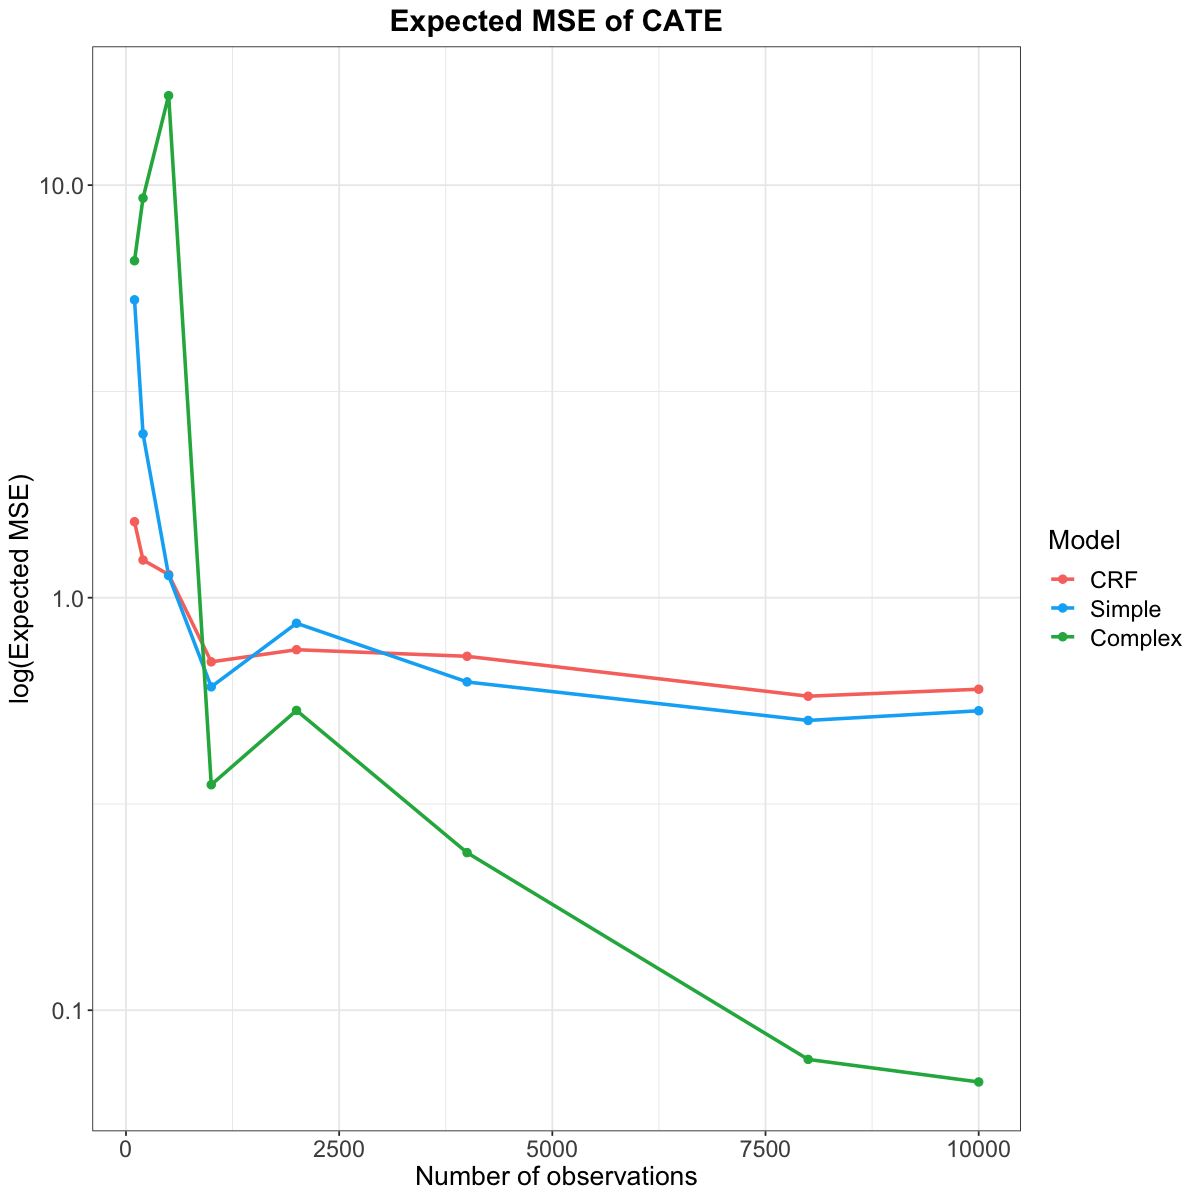

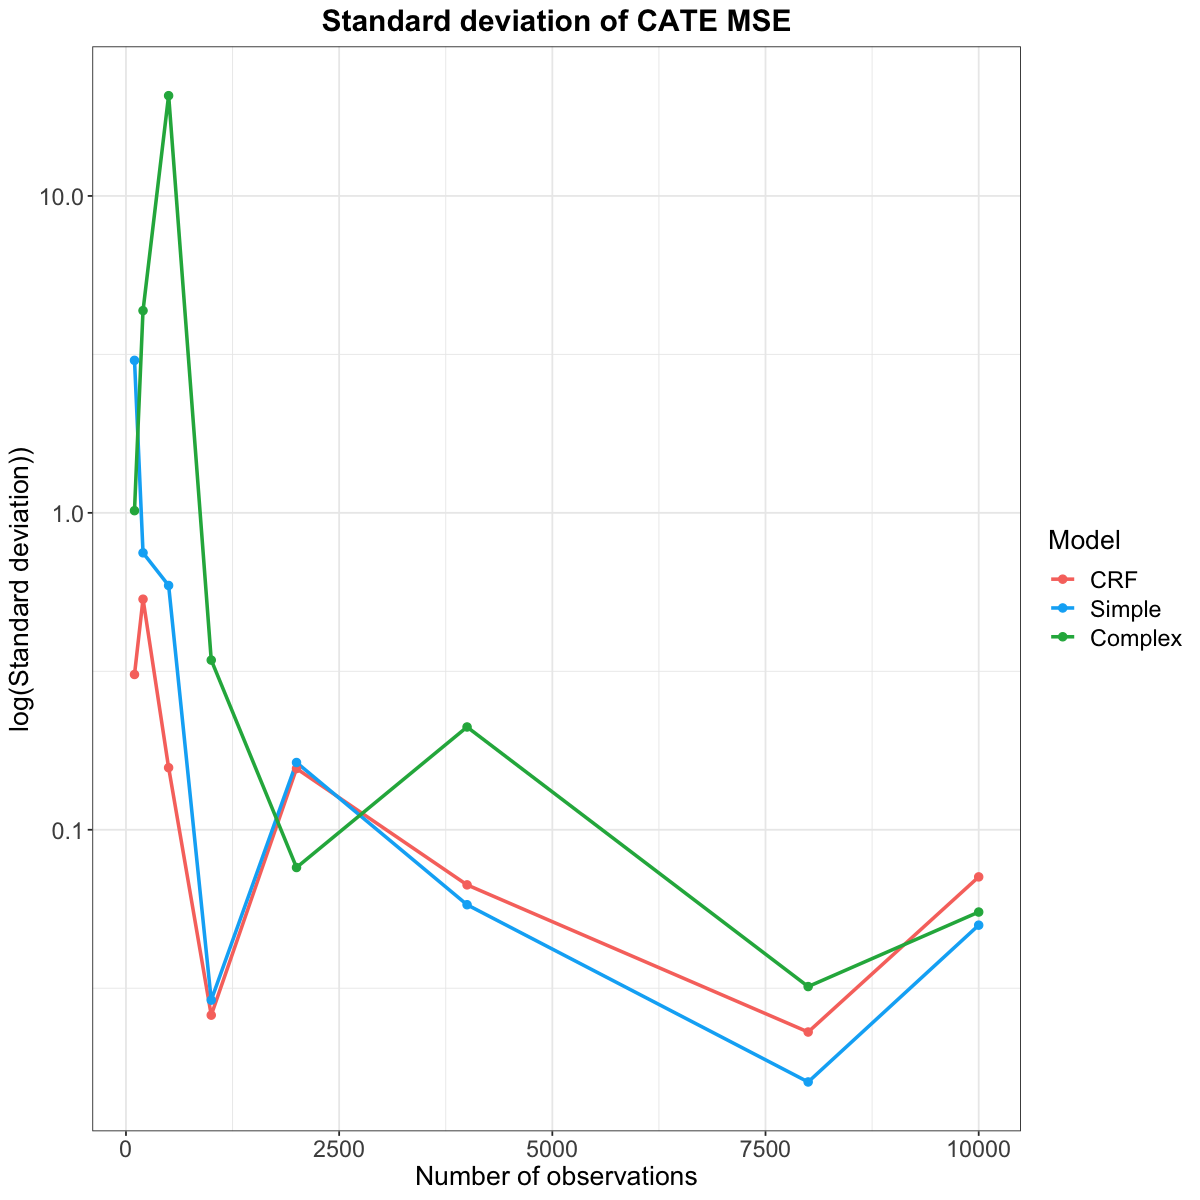

In [17]:
### CATE Results Graphs - Simulation Study 1 (Observations) 

# Generate datasets for graphs

graph_CATE_EMSE <- dataset_graph(data=Table_CATE_obs,vars=c("EMSE_CATE_crf","EMSE_CATE_simple","EMSE_CATE_complex"))
graph_CATE_sd <- dataset_graph(data=Table_CATE_obs,vars=c("MSE_CATE_crf_sd","MSE_CATE_simple_sd","MSE_CATE_complex_sd"))

options(repr.plot.width=10, repr.plot.height=10)

ggplot(data=graph_CATE_EMSE,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="log(Expected MSE)",title="Expected MSE of CATE") +
    scale_y_continuous(trans="log10") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 

ggplot(data=graph_CATE_sd,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="log(Standard deviation))",title="Standard deviation of CATE MSE") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    scale_y_continuous(trans="log10") +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 

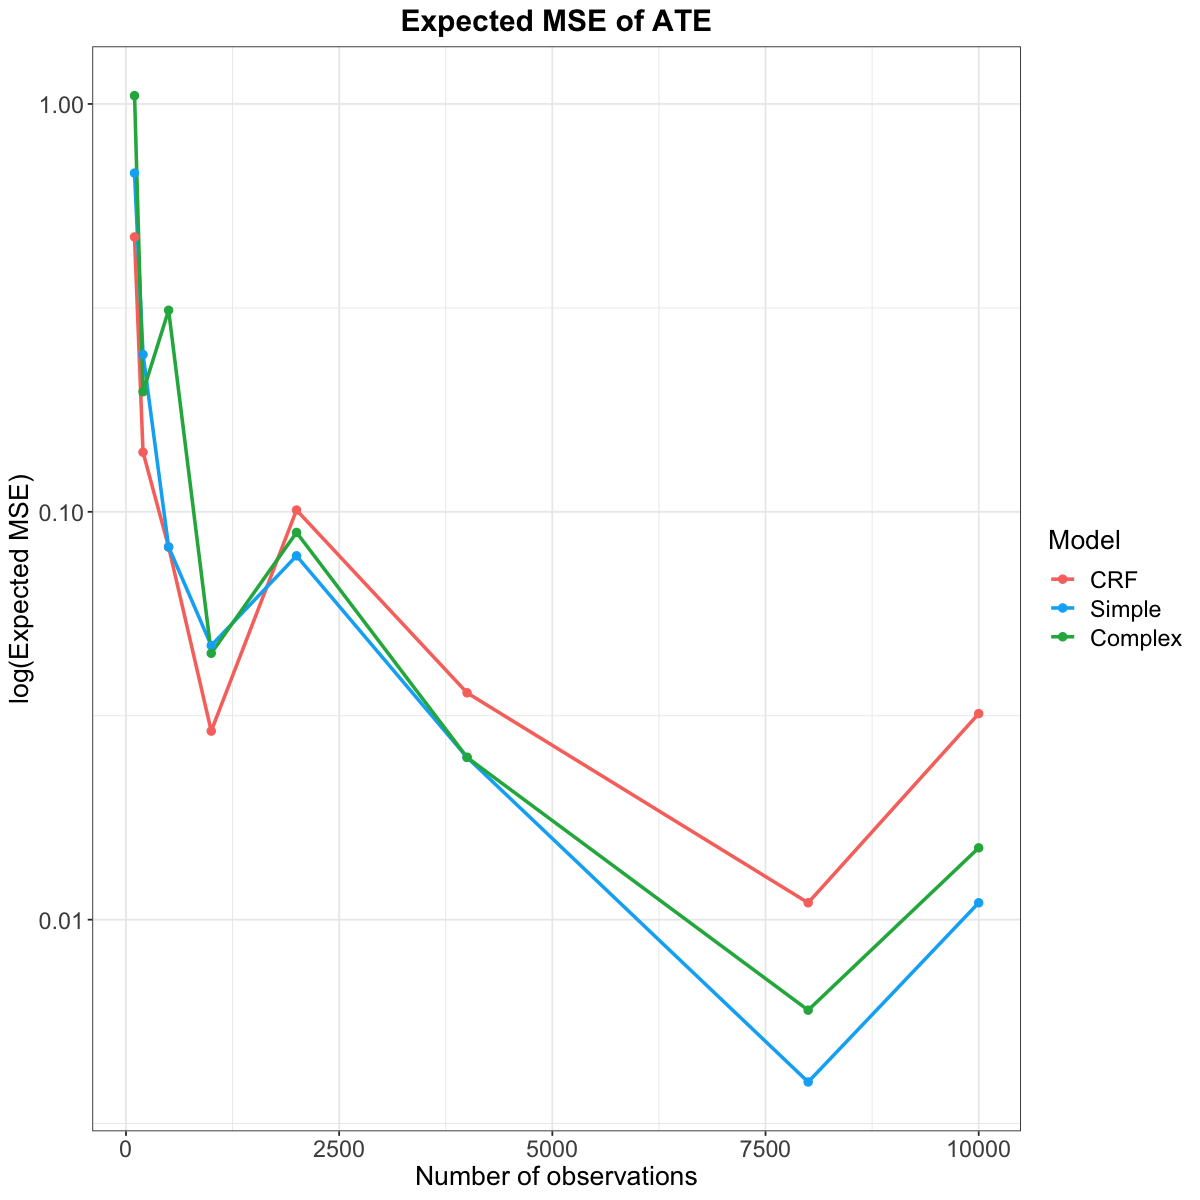

In [19]:
### ATE Graphs - Simulation Study 1 (Observations) 

# Generate datasets for graphs

graph_ATE_EMSE <- dataset_graph(data=Table_ATE_obs,vars=c("EMSE_ATE_crf","EMSE_ATE_simple","EMSE_ATE_complex"))

options(repr.plot.width=10, repr.plot.height=10)

ggplot(data=graph_ATE_EMSE,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="log(Expected MSE)",title="Expected MSE of ATE") +
    scale_y_continuous(trans="log10") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 

### 4.3 High-dimensional Data

In [20]:
### Set up noise variables

n_noise = 20
N = 1000

set.seed(123)
gamma_true_val = runif(n=6000,-1,1)
Sigma_noise_val = diag(6000)

In [21]:
### Simulation study with CRF

set.seed(123)
results_noise_crf = crf_sim_noise(n_noise_vec=c(10,50,100,200,500,750,900,950,980,1500,3000,5000),m=2,dgp_complex=F,n_obs=100)

10

1

2

50

1

2

100

1

2

200

1

2

500

1

2

750

1

2

900

1

2

950

1

2

980

1

2

1500

1

2

3000

1

2

5000

1

2



In [22]:
### Simulation study with linear model

set.seed(123)
results_noise_ols = ols_sim_noise(n_noise_vec=c(10,50,100,200,500,750,900,950,980),m=2,dgp_complex=F,n_obs=1000)

10

1

2

50

1

2

100

1

2

200

1

2

500

1

2

750

1

2

900

1

2

950

1

2

980

1

2



In [23]:
results_noise_crf

,n_noise,n_noise,n_noise,n_noise,n_noise,n_noise,n_noise,n_noise,n_noise,n_noise,n_noise,n_noise
Noise,10.00000000,50.000000,100.0000000,200.000000,500.0000000,750.000000,900.000000,950.000000,980.000000,1500.000000,3000.00000,5000.0000
EMSE_CATE_crf,1.05358305,2.844224,1.7914995,5.802768,4.9326497,4.764344,6.602151,4.892829,21.688767,11.509659,11.04069,189.7012
MSE_CATE_crf_sd,0.11126437,2.470549,0.8934779,6.420090,0.7180966,1.798521,7.295421,4.633971,5.100233,1.250117,10.52401,185.0904
EMSE_ATE_crf,0.02942679,1.852587,0.5592398,4.643804,3.7395688,3.603747,5.315909,3.554827,20.555472,9.112844,11.65901,198.7655
MSE_ATE_crf_sd,0.02874655,2.482303,0.7906345,6.559558,0.4186006,1.385735,7.233337,4.135390,2.827122,2.385943,10.74576,199.5162


In [24]:
# Prepare summary tables 

results_noise_crf <- data.frame(results_noise_crf)
names(results_noise_crf) <- results_noise_crf["Noise",]
results_noise_crf <- t(results_noise_crf)

results_noise_ols <- data.frame(results_noise_ols)
names(results_noise_ols) <- results_noise_ols["Noise",]
results_noise_ols <- t(results_noise_ols)

results_noise <- merge(x=results_noise_crf,y=results_noise_ols,all=TRUE)
results_noise <- data.frame(t(results_noise))
names(results_noise) <- results_noise["Noise",]

### Table with CATE EMSE results for different dimensions

Table_CATE_noise = round(results_noise[c("EMSE_CATE_crf","MSE_CATE_crf_sd","EMSE_CATE_simple","MSE_CATE_simple_sd","EMSE_CATE_complex","MSE_CATE_complex_sd"),],3)
Table_CATE_noise

### Table with ATE EMSE results for different dimensions

Table_ATE_noise = round(results_noise[c("EMSE_ATE_crf","MSE_ATE_crf_sd","EMSE_ATE_simple","MSE_ATE_simple_sd","EMSE_ATE_complex","MSE_ATE_complex_sd"),],3)
Table_ATE_noise

,10,50,100,200,500,750,900,950,980,1500,3000,5000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMSE_CATE_crf,1.054,2.844,1.791,5.803,4.933,4.764,6.602,4.893,21.689,11.51,11.041,189.701
MSE_CATE_crf_sd,0.111,2.471,0.893,6.420,0.718,1.799,7.295,4.634,5.100,1.25,10.524,185.090
EMSE_CATE_simple,0.933,0.946,0.910,0.788,1.516,1.504,5.160,9.673,67.267,NA,NA,NA
MSE_CATE_simple_sd,0.330,0.390,0.322,0.305,0.264,0.970,0.963,3.854,14.607,NA,NA,NA
EMSE_CATE_complex,0.720,0.753,0.768,0.527,1.508,1.685,11.945,18.840,50.673,NA,NA,NA
MSE_CATE_complex_sd,0.606,0.592,0.631,0.485,0.227,0.593,1.108,3.339,55.562,NA,NA,NA


,10,50,100,200,500,750,900,950,980,1500,3000,5000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EMSE_ATE_crf,0.029,1.853,0.559,4.644,3.740,3.604,5.316,3.555,20.555,9.113,11.659,198.766
MSE_ATE_crf_sd,0.029,2.482,0.791,6.560,0.419,1.386,7.233,4.135,2.827,2.386,10.746,199.516
EMSE_ATE_simple,0.063,0.074,0.019,0.022,0.389,0.108,1.081,1.160,2.153,NA,NA,NA
MSE_ATE_simple_sd,0.006,0.022,0.007,0.019,0.119,0.025,0.732,0.566,1.424,NA,NA,NA
EMSE_ATE_complex,0.049,0.062,0.009,0.010,0.373,0.073,0.907,1.418,1.840,NA,NA,NA
MSE_ATE_complex_sd,0.010,0.018,0.003,0.011,0.171,0.061,0.712,0.920,2.582,NA,NA,NA


Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


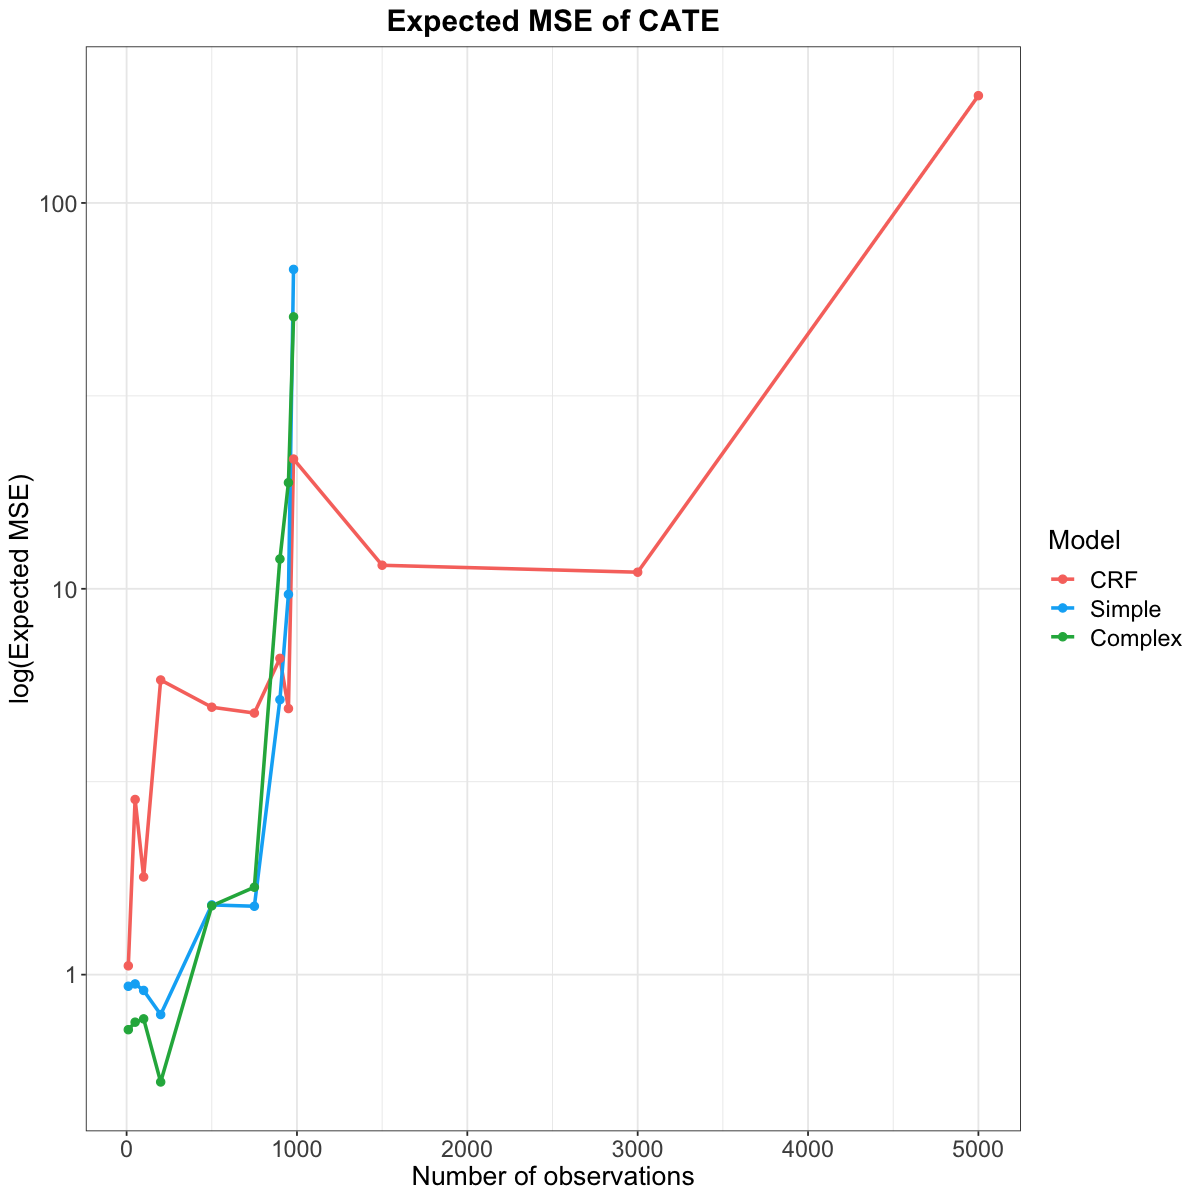

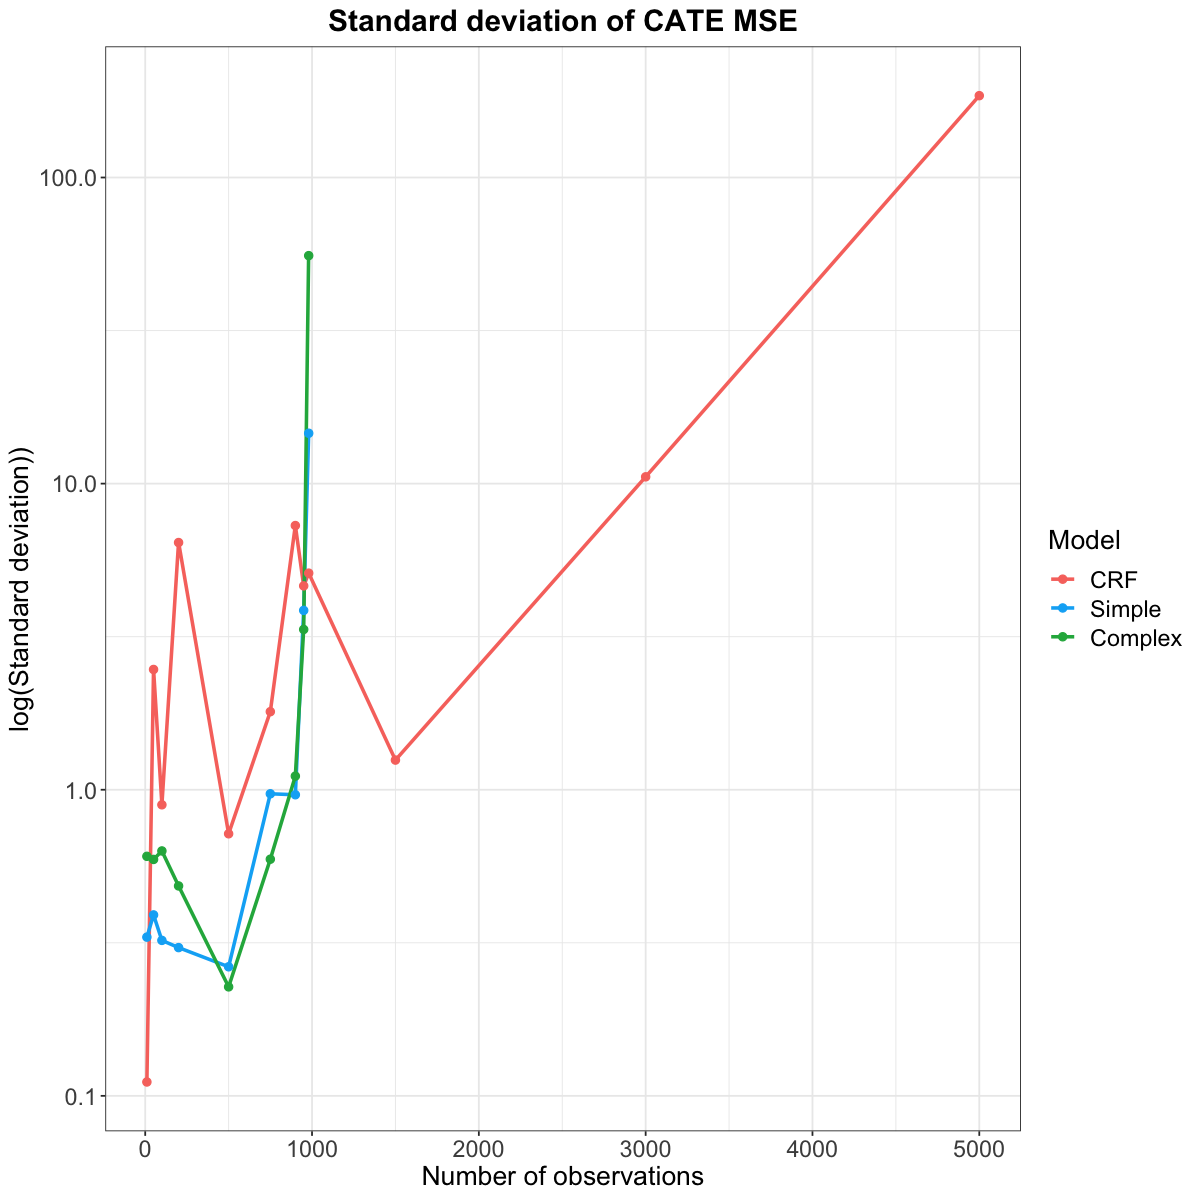

In [25]:
graph_CATE_EMSE_noise <- dataset_graph(data=Table_CATE_noise,vars=c("EMSE_CATE_crf","EMSE_CATE_simple","EMSE_CATE_complex"))
graph_CATE_sd_noise <-dataset_graph(data=Table_CATE_noise,vars=c("MSE_CATE_crf_sd","MSE_CATE_simple_sd","MSE_CATE_complex_sd"))

ggplot(data=graph_CATE_EMSE_noise,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="log(Expected MSE)",title="Expected MSE of CATE") +
    scale_y_continuous(trans="log10") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 

ggplot(data=graph_CATE_sd_noise,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="log(Standard deviation))",title="Standard deviation of CATE MSE") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    scale_y_continuous(trans="log10") +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16))

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


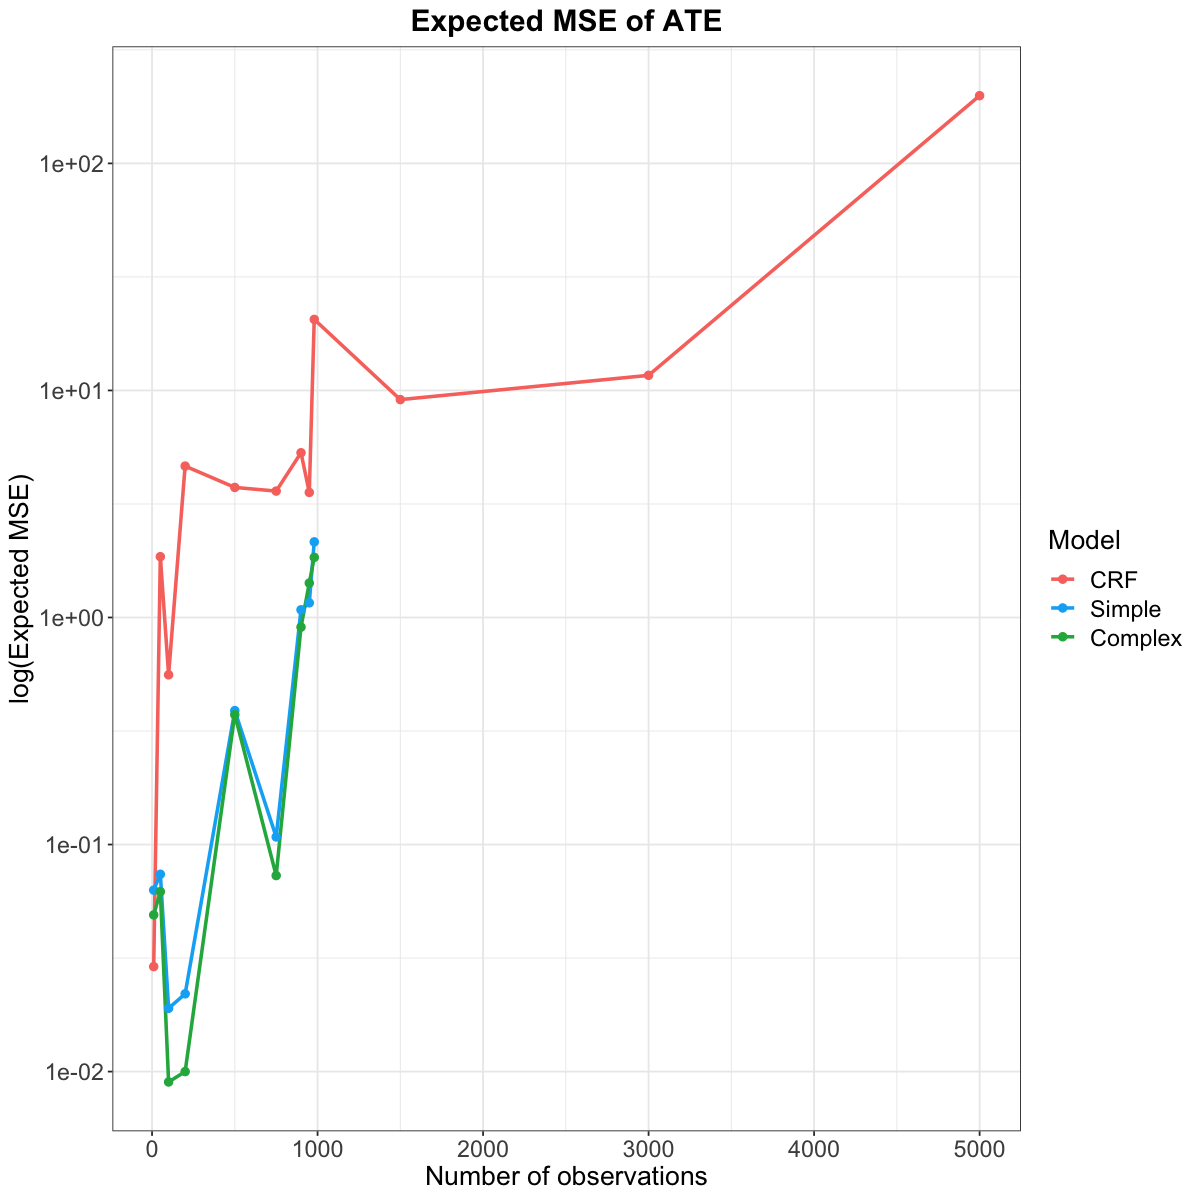

In [26]:
graph_ATE_EMSE_noise <- dataset_graph(data=Table_ATE_noise,vars=c("EMSE_ATE_crf","EMSE_ATE_simple","EMSE_ATE_complex"))

ggplot(data=graph_ATE_EMSE_noise,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="log(Expected MSE)",title="Expected MSE of ATE") +
    scale_y_continuous(trans="log10") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 


# 5. Conclusion

# 6. Bibliography 

In [ ]:
##foldnormal = foldnorm.mle(prior_t01)
#
#prior_adj = data$prior 
#prior_adj[prior_adj==0] = 0.01
#
#lognormal = fitdistr(prior_adj, "log-normal")
#chi2 = fitdistr(prior_adj, "chi-squared",start=list(df=1),lower = 1)
#exponential = fitdistr(data$prior , "exponential",lower = 0)
#weibull = fitdistr(prior_adj, "weibull",start=list(shape=0,scale=1),lower=c(0.1,0.1))
#gamma = fitdistr(prior_adj, "gamma",start=list(shape=0,scale=1),lower=c(0.1,0.1))
#
#objects(exponential)
#
#x = seq(0,100,0.1)
#
#hist(data$prior,ylim=c(0,2500),xlim=c(0,100),breaks=n_breaks,col = "lightgrey",main="Histogram of prior",xlab="prior")
##lines(x=x,y=dexp(x, rate=exponential))
#
#
##plot(x,dchisq(x, df=chi2),type="l")
##plot(x,dlnorm(x, mean=lognormal[1],sd=lognormal[2]),type="l")
##plot(x,dweibull(x, shape=weibull[1], scale = weibull[2]),type="l")
##plot(x,dgamma(x, shape=gamma[1], scale = gamma[2]),type="l")
#
#round(AIC(chi2))
#round(AIC(lognormal))
#round(AIC(exponential))
#round(AIC(weibull))
#round(AIC(gamma))
#
#
#ks.test(x=data$prior,y="pexp",rate=exp_fit$estimate)
#
#gamma <- fitdist(prior_adj,"gamma")
#
#plot(gamma)
#gofstat(gamma)
#
#
#
#

In [ ]:
### BACKUP: Correction of EMSE calculation

#### Calculate average of MSE and ATE
#    
#    tau_hat_simple = results_simple_Y1 - results_simple_Y0
#    tau_hat_complex = results_complex_Y1 - results_complex_Y0
#    tau_true = results_true_Y1 - results_true_Y0
#    
#    MSE_simple = colMeans((tau_hat_simple - tau_true)^2)
#    MSE_complex = colMeans((tau_hat_complex - tau_true)^2)
#    
#    ATE_simple = colMeans(results_simple_Y1) - colMeans(results_simple_Y0)
#    ATE_complex = colMeans(results_complex_Y1) - colMeans(results_complex_Y0)
#    ATE_true = colMeans(results_true_Y1) - colMeans(results_true_Y0)
#    
#    MSE_simple_avg = mean(MSE_simple,na.rm=T)
#    MSE_complex_avg = mean(MSE_complex,na.rm=T)
#    
#    MSE_simple_sd = sd(MSE_simple,na.rm=T)
#    MSE_complex_sd = sd(MSE_complex,na.rm=T)
#    
#    ATE_simple_avg = mean(ATE_simple,na.rm=T)
#    ATE_complex_avg = mean(ATE_complex,na.rm=T)
#    ATE_true_avg = mean(ATE_true,na.rm=T)
#    
#    ATE_simple_sd = sd(ATE_simple,na.rm=T)
#    ATE_complex_sd = sd(ATE_complex,na.rm=T)
#    ATE_true_sd = sd(ATE_true,na.rm=T)
#    
#    col = rbind(col,MSE_simple_avg,MSE_simple_sd,MSE_complex_avg,MSE_complex_sd,ATE_simple_avg,ATE_simple_sd,ATE_complex_avg,ATE_complex_sd,ATE_true_avg,ATE_true_sd )
#    final_table = cbind(final_table,col)
#    
#  }

In [ ]:
### Results Graphs - Simulation Study 1 (Observations) 

graph_obs_ols = as.data.frame(t(results_obs_ols))
graph_obs_crf = as.data.frame(t(results_obs_crf))

graph_obs_ols$Obs = as.numeric(row.names(graph_obs_ols))
graph_obs_crf$Obs = as.numeric(row.names(graph_obs_crf))

ggplot() +
    geom_line(data=graph_obs_crf,aes(x=Obs,y=EMSE_CATE_crf,fill="Test"),color="red",size=1) +
    geom_line(data=graph_obs_ols,aes(x=Obs,y=EMSE_CATE_simple,color="s"),color="blue",size=1) + 
    geom_line(data=graph_obs_ols,aes(x=Obs,y=EMSE_CATE_complex,color="d"),color="darkgreen",size=1) +

    labs(x="Number of observations",y="log(Expected MSE of CATE)",title="Expected MSE of CATE") +
    scale_fill_manual() 
    
    

In [ ]:
test = pivot_longer(graph_obs_crf[,c("EMSE_CATE_crf","EMSE_ATE_crf","Obs")],cols=c("EMSE_CATE_crf","EMSE_ATE_crf"))

In [ ]:
test

In [ ]:
names(test) <- c("Obs","Name","Value")

In [ ]:
ggplot(data=test,aes(x=Obs)) +
    geom_line(aes(y=Value,color=Name))

In [ ]:
graph_CATE_EMSE <- data.frame(t(Table_CATE[c("EMSE_CATE_crf","EMSE_CATE_simple","EMSE_CATE_complex"),]))
graph_CATE_EMSE$Obs <- as.numeric(row.names(graph_CATE_EMSE))
graph_CATE_EMSE <- pivot_longer(graph_CATE_EMSE,cols=c("EMSE_CATE_crf","EMSE_CATE_simple","EMSE_CATE_complex"))
names(graph_CATE_EMSE) <- c("Obs","Model","Value")
graph_CATE_EMSE$Model <- factor(graph_CATE_EMSE$Model,levels=c("EMSE_CATE_crf","EMSE_CATE_simple","EMSE_CATE_complex"))

In [ ]:
graph_CATE_sd <- data.frame(t(Table_CATE[c("MSE_CATE_crf_sd","MSE_CATE_simple_sd","MSE_CATE_complex_sd"),]))
graph_CATE_sd$Obs <- as.numeric(row.names(graph_CATE_sd))
graph_CATE_sd <- pivot_longer(graph_CATE_sd,cols=c("MSE_CATE_crf_sd","MSE_CATE_simple_sd","MSE_CATE_complex_sd"))
names(graph_CATE_sd) <- c("Obs","Model","Value")
graph_CATE_sd$Model <- factor(graph_CATE_sd$Model,levels=c("MSE_CATE_crf_sd","MSE_CATE_simple_sd","MSE_CATE_complex_sd"))

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(data=graph_CATE_EMSE,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="log(Expected MSE of CATE)",title="Expected MSE of CATE") +
    scale_y_continuous(trans="log10") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(data=graph_CATE_sd,aes(x=Obs)) +
    theme_bw() +
    geom_line(aes(y=Value,color=Model),size=1) +
    geom_point(aes(y=Value,color=Model),size=2) +
    labs(x="Number of observations",y="log(Standard deviation))",title="Standard deviation of CATE MSE") +
    scale_color_manual(name="Model",labels=c("CRF","Simple","Complex"),values = c("#f8766d", "#00b0f6", "#22B14C")) +
    scale_y_continuous(trans="log10") +
    theme(plot.title=element_text(size=18,face="bold",hjust=0.5),axis.text.x=element_text(size=14),axis.text.y=element_text(size=14),legend.title=element_text(size=16),legend.text=element_text(size=14),axis.title=element_text(size=16)) 

In [ ]:
### Backup

#### Results Graphs - Simulation Study 1 (Observations) 
#
#graph_obs_ols = as.data.frame(t(results_obs_ols))
#graph_obs_crf = as.data.frame(t(results_obs_crf))
#
#graph_obs_ols$Obs = as.numeric(row.names(graph_obs_ols))
#graph_obs_crf$Obs = as.numeric(row.names(graph_obs_crf))
#
#ggplot() +
#    theme_bw() +
#    geom_line(data=graph_obs_crf,aes(x=Obs,y=EMSE_CATE_crf,color="Test"),color="red",size=1) +
#    geom_line(data=graph_obs_ols,aes(x=Obs,y=EMSE_CATE_simple),color="blue",size=1) + 
#    geom_line(data=graph_obs_ols,aes(x=Obs,y=EMSE_CATE_complex),color="darkgreen",size=1) +
#
#    geom_point(data=graph_obs_ols,aes(x=Obs,y=EMSE_CATE_simple),color="blue",size=2) + 
#    geom_point(data=graph_obs_ols,aes(x=Obs,y=EMSE_CATE_complex),color="darkgreen",size=2) + 
#    geom_point(data=graph_obs_crf,aes(x=Obs,y=EMSE_CATE_crf),color="red",size=2) +
#
#    labs(x="Number of observations",y="log(Expected MSE of CATE)",title="Expected MSE of CATE") +
#    scale_y_continuous(trans="log10") +
#    scale_color_manual(values = colors) +
#    theme(plot.title=element_text(size=14,face="bold",hjust=0.5)) 
#    
#
#ggplot() +
#    theme_bw() + 
#    geom_line(data=graph_obs_crf,aes(x=Obs,y=MSE_CATE_crf_sd),color="red",size=1) +
#    geom_line(data=graph_obs_ols,aes(x=Obs,y=MSE_CATE_simple_sd),color="blue",size=1) + 
#    geom_line(data=graph_obs_ols,aes(x=Obs,y=MSE_CATE_complex_sd),color="darkgreen",size=1) +
#
#    geom_point(data=graph_obs_ols,aes(x=Obs,y=MSE_CATE_simple_sd),color="blue",size=2) + 
#    geom_point(data=graph_obs_ols,aes(x=Obs,y=MSE_CATE_complex_sd),color="darkgreen",size=2) + 
#    geom_point(data=graph_obs_crf,aes(x=Obs,y=MSE_CATE_crf_sd),color="red",size=2) +
#    
#    labs(x="Number of observations",y="log(Standard deviation MSE of CATE)",title="Standard deviation MSE of CATE") +
#    scale_y_continuous(breaks=c(1,10),trans="log10") +
#    theme(plot.title=element_text(size=14,face="bold",hjust=0.5)) 

In [ ]:
Table_ATE

In [ ]:
graph_CATE_EMSE <- dataset_graph(data=Table_ATE,vars=c("EMSE_ATE_crf","EMSE_ATE_simple","EMSE_ATE_complex"))
graph_CATE_sd <- dataset_graph(data=Table_ATE,vars=c("MSE_ATE_crf_sd","MSE_ATE_simple_sd","MSE_ATE_complex_sd"))

